In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
%matplotlib inline

In [2]:
model = tf.keras.models.load_model('mobilenet003.h5')

In [3]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [4]:
import os
current_dir = os.getcwd()
print(current_dir)

G:\Datasets\COVID-XRAY\main_dataset


In [5]:
image_dim = [224,224]

epochs = 100
batch_size = 32

covid_path = os.path.join(current_dir + '/chest/Chest_COVID')
noncovid_path = os.path.join(current_dir + '/chest/Chest_NonCOVID')

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')


In [6]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_NonCOVID')

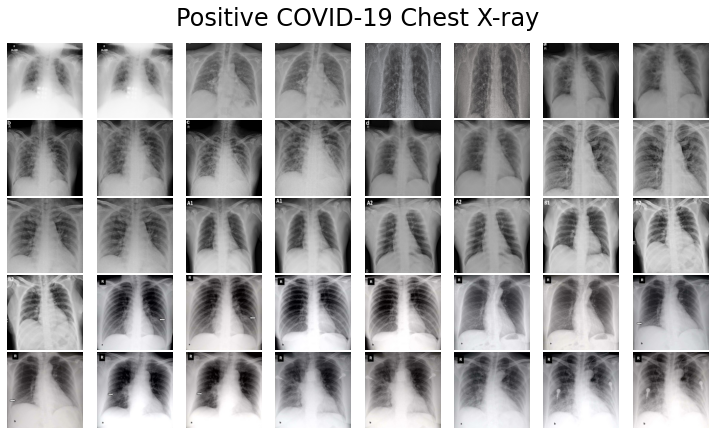

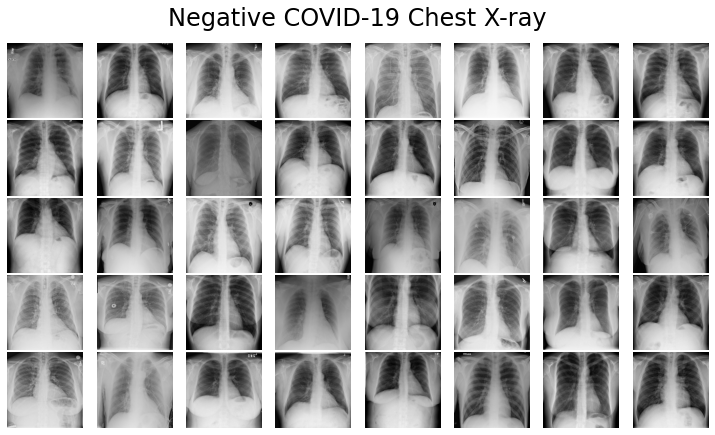

In [7]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [8]:
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

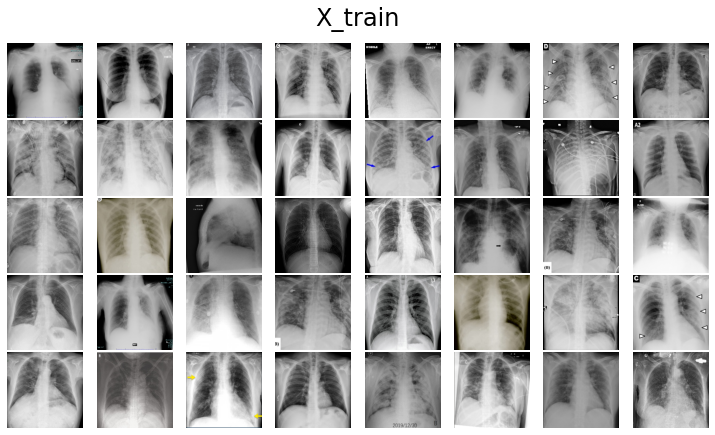

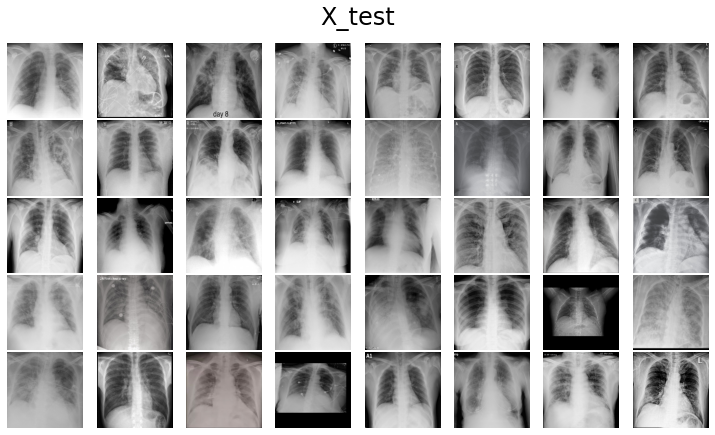

In [10]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

In [11]:
import tensorflow
model.compile(
        loss='categorical_crossentropy', 
        optimizer=tensorflow.keras.optimizers.Adadelta(learning_rate = 0.001), 
        metrics=['accuracy']
)
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range = 0.1
)

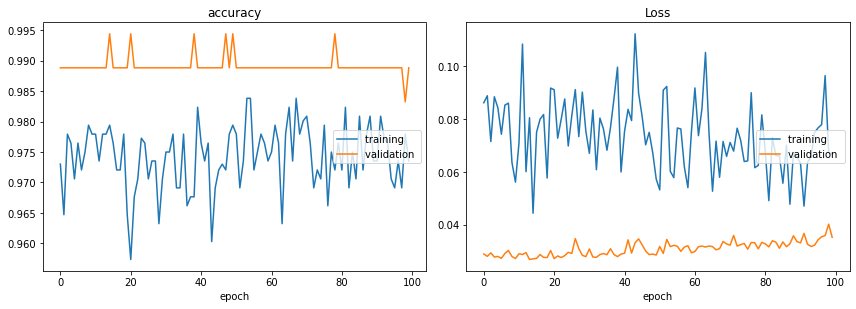

accuracy
	training         	 (min:    0.957, max:    0.984, cur:    0.974)
	validation       	 (min:    0.983, max:    0.994, cur:    0.989)
Loss
	training         	 (min:    0.044, max:    0.112, cur:    0.067)
	validation       	 (min:    0.027, max:    0.040, cur:    0.035)
22/22 [==============================] - 8s 359ms/step - loss: 0.0667 - accuracy: 0.9735 - val_loss: 0.0353 - val_accuracy: 0.9888


In [12]:
from livelossplot import PlotLossesKerasTF

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) // 32,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=100,
                   callbacks = [PlotLossesKerasTF()])

In [13]:
model.save_weights('mobilenet003_retrain.h5')
model.load_weights('mobilenet003_retrain.h5')

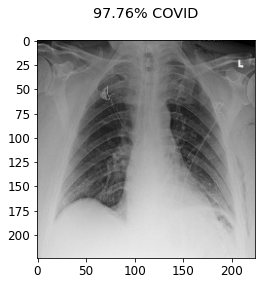

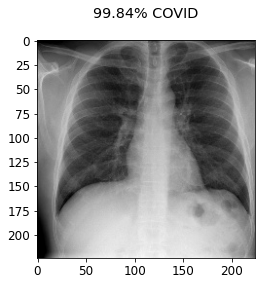

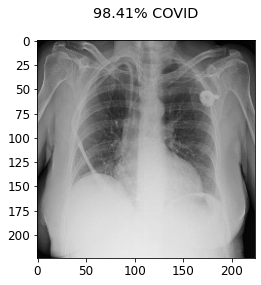

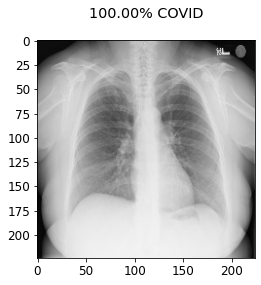

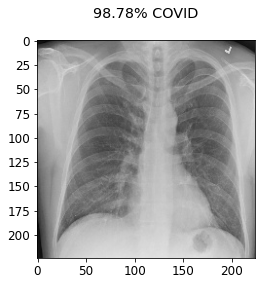

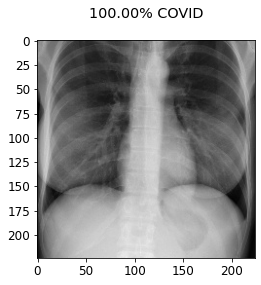

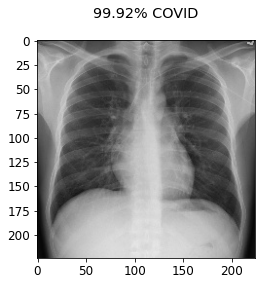

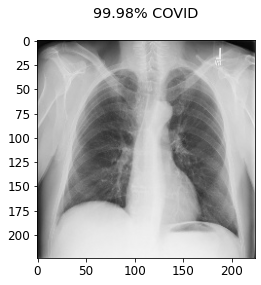

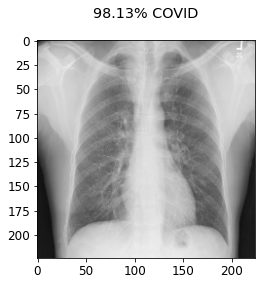

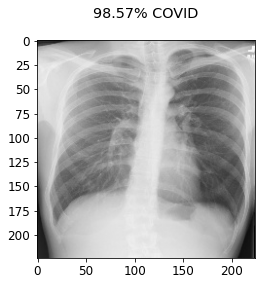

In [22]:
y_pred = model.predict(X_test, batch_size=batch_size)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
    if probability[1] > 0.7:
        plt.title('%.2f' % (probability[1]*100) + '% COVID' + '\n' )
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
    plt.imshow(X_test[index])
    plt.show()

In [23]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

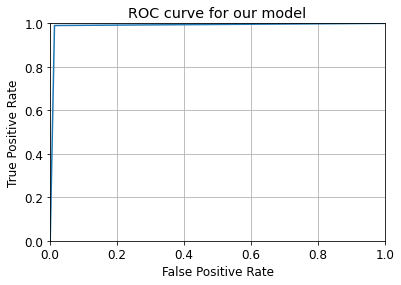

In [24]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


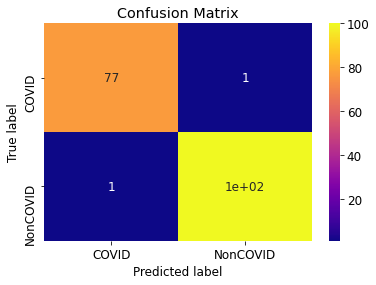

Confusion Matrix with Normalized Values


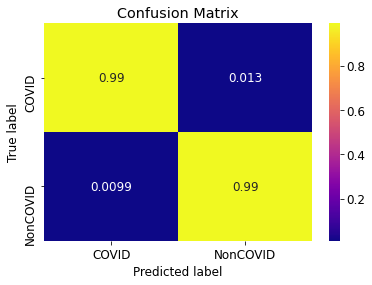

In [25]:
def plot_confusion_matrix(normalize):
    classes = ['COVID','NonCOVID']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        78
           1       0.99      0.99      0.99       101

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



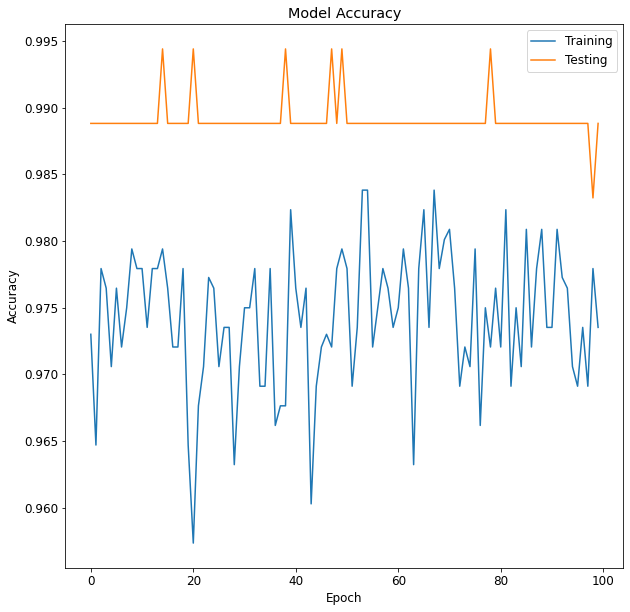

In [19]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet003_acc_retrain.png')
plt.show()


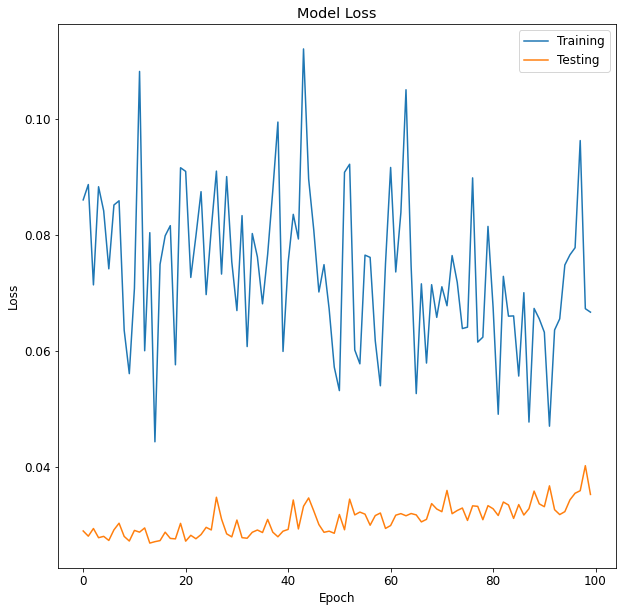

In [20]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet003_retrain.png')
plt.show()

In [27]:
#!pip install gradio
import gradio as gr
labels = ['COVID +ve', 'Normal']

def classify_image(inp):
    inp = inp.reshape((-1, 244, 244, 3))
    inp = tensorflow.keras.applications.mobilenet_v2.preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(2)}



image = gr.inputs.Image(shape=(244, 244, 3))
label = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch()

Running locally at: http://127.0.0.1:7861/


(<gradio.networking.serve_files_in_background.<locals>.HTTPServer at 0x290f8719d48>,
 'http://127.0.0.1:7861/',
 None)